In [1]:
import numpy as np
import matplotlib.pyplot as plt
import clip
import torch

In [2]:
import pickle
import uuid
import string
import regex as re
from collections import defaultdict
import os, glob
from tqdm import tqdm

# Load data

In [3]:
with open('meme_900k_cleaned_data.pkl', 'rb') as f:
    data = pickle.load(f)

In [4]:
data.keys()

dict_keys(['label_uuid_dic', 'uuid_label_dic', 'uuid_caption_dic', 'uuid_image_path_dic'])

In [9]:
uuid_to_image = data['uuid_image_path_dic']

In [10]:
key1 = next(iter(uuid_to_image.keys()))
uuid_to_image[key1]

'/home/s1hegde/teams/shaolin-monkeys/memes900k/images/hipster-ariel.jpg'

In [11]:
key1

'0b9dcf07-b9a0-4807-b652-3230183b2461'

In [12]:
label = data['uuid_label_dic'][key1]

In [13]:
all_keys = list(data['uuid_label_dic'].keys())
all_keys[:10]

['d6daa8ba-ba36-4249-a2ef-3834dc5a0a84',
 '347f75d7-4dcb-4099-b6c5-ea18b9f2d293',
 '2fea4f16-0c87-4af6-b477-7bea5e0c5190',
 '66002f2b-65ce-484d-ba2e-14c513fc1694',
 'd055c08b-d438-4fc0-92a8-f387071758e3',
 '277529ee-9327-4f30-9380-6fdd6d620d9c',
 '60d13355-38b3-475f-b565-514bcd495977',
 '18886559-9287-4fd0-94e0-b3f1a5c7ee2b',
 'ce6d3b49-8929-4bf3-85f0-c073dfe10a0a',
 'b1766706-c6ce-474d-ad1a-1cd047e636b1']

In [14]:
key1 in data['uuid_label_dic']

True

In [15]:
key1 in data['uuid_image_path_dic']

True

In [16]:
key1 in data['uuid_caption_dic']

True

In [17]:
'hipster-ariel' in data['label_uuid_dic']

True

In [18]:
data['label_uuid_dic']['hipster-ariel']

'0b9dcf07-b9a0-4807-b652-3230183b2461'

In [19]:
key1 == 'a3ba9a78-b0fe-45b0-a0de-75e15fe17530'

False

In [20]:
ex_labels = list(data['label_uuid_dic'].keys())[:3]

# CLIP Embeddings

Let's test whether CLIP can match a meme template to it's label

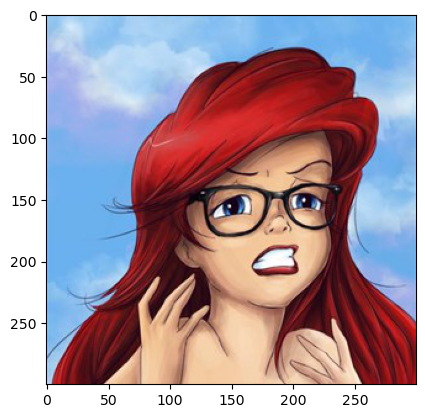

In [21]:
from PIL import Image

img_path = uuid_to_image[key1]
img = Image.open(img_path)
plt.imshow(img)
plt.show()

In [25]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

image = preprocess(Image.open(img_path)).unsqueeze(0).to(device)
label_list = ex_labels+ ['hipster ariel']
label_list = [' '.join(x.split('-')) for x in label_list]
print(label_list)
text = clip.tokenize(label_list).to(device)

with torch.no_grad():
    image_features = model.encode_image(image)
    text_features = model.encode_text(text)
    
    logits_per_image, logits_per_text = model(image, text)
    probs = logits_per_image.softmax(dim=-1).cpu().numpy()

print("Label probs:", probs)
print("Predicted Match: ", label_list[np.argmax(probs)])

['your country needs you', 'philosoraptor', 'san juan cholo', 'hipster ariel']
Label probs: [[1.2e-07 6.0e-08 1.2e-06 1.0e+00]]
Predicted Match:  hipster ariel


It even works for y-u-no! 

TO-DO: What dataset was the _ViT-B/32_ version of CLIP trained on? Was it trained on memes as well?

In [26]:
label='y-u-no'
uuid = data['label_uuid_dic'][label]
img_path = data['uuid_image_path_dic'][uuid]

image = preprocess(Image.open(img_path)).unsqueeze(0).to(device)
label_list = ex_labels+[label]
label_list = [' '.join(x.split('-')) for x in label_list]
print(label_list)
text = clip.tokenize(label_list).to(device)

with torch.no_grad():
    image_features = model.encode_image(image)
    text_features = model.encode_text(text)
    
    logits_per_image, logits_per_text = model(image, text)
    probs = logits_per_image.softmax(dim=-1).cpu().numpy()

print("Label probs:", probs)
print("Predicted Match: ", label_list[np.argmax(probs)])

['your country needs you', 'philosoraptor', 'san juan cholo', 'y u no']
Label probs: [[9.823e-04 2.016e-03 3.140e-04 9.966e-01]]
Predicted Match:  y u no


# Generate Image Features

In [27]:
uuid_feature_dic = {}
all_paths = list(data['uuid_image_path_dic'].values())
all_uuids = list(data['uuid_image_path_dic'].keys())

for i in tqdm(range(len(all_paths))):
    uuid = all_uuids[i]
    img_path = all_paths[i]
    image = preprocess(Image.open(img_path)).unsqueeze(0).to(device)
    with torch.no_grad():
        image_features = model.encode_image(image)
    uuid_feature_dic[uuid] = image_features

100%|██████████| 300/300 [00:21<00:00, 13.65it/s]


# Zero Shot Testing for Different User prompts

In [28]:
user_prompts = ['Why is my coffee so damn hot?', "I don't know if my teacher is laughing or crying", "Where is my Pizza?"]


In [29]:
text = clip.tokenize(user_prompts).to(device)
image_features = torch.vstack(list(uuid_feature_dic.values()))
print(image_features.shape)


torch.Size([300, 512])


In [30]:
with torch.no_grad():
    text_features = model.encode_text(text)
# Pick the top 5 most similar labels for the image
image_features /= image_features.norm(dim=-1, keepdim=True)
text_features /= text_features.norm(dim=-1, keepdim=True)
similarity = (100.0 * image_features @ text_features.T).softmax(dim=-1)
similarity = similarity.detach().cpu().numpy()

In [31]:
label_inds = np.argmax(similarity, axis=0)
uuids = [all_uuids[i] for i in label_inds]

In [32]:
uuids

['3916f238-fcf4-459a-b711-77bd948eb9e0',
 'd3da6277-c6dc-481c-a85e-1bf9943f058a',
 'b0b38930-4405-4cb4-8299-3e86c793ddc3']

In [33]:
retrieved_paths = [all_paths[i] for i in label_inds]
print(retrieved_paths)

['/home/s1hegde/teams/shaolin-monkeys/memes900k/images/kermit-the-frog-drinking-tea.jpg', '/home/s1hegde/teams/shaolin-monkeys/memes900k/images/obama-laughing.jpg', '/home/s1hegde/teams/shaolin-monkeys/memes900k/images/fat-chinese-kid.jpg']


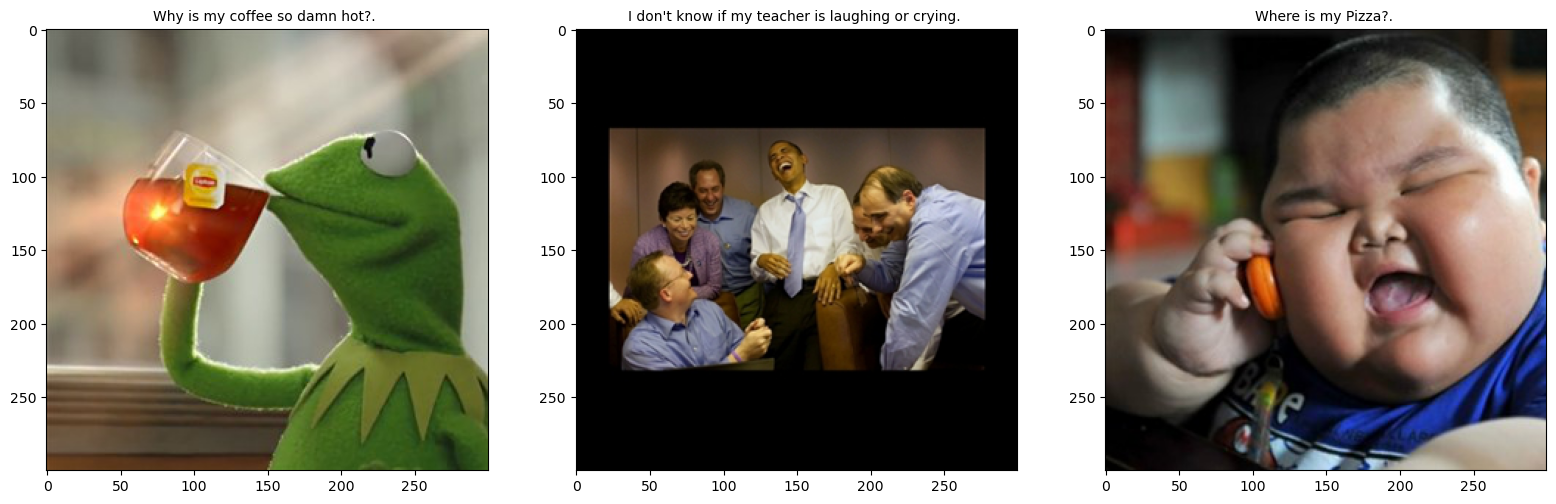

In [34]:
plt.figure(figsize=(8, 20))
plt.rcParams["axes.titlesize"] = 10
for i, img_path in enumerate(retrieved_paths):
    image = Image.open(img_path)
    plt.subplot(1, len(retrieved_paths), i+1)
    plt.imshow(image)
    plt.title(f"{user_prompts[i]}. ", loc='center', wrap=True)
plt.subplots_adjust(right=2)
plt.show()

## Text to Label 

In [35]:
all_labels = list(data['label_uuid_dic'].keys())

In [36]:
label_text = clip.tokenize(list(data['label_uuid_dic'].keys())).to(device)

In [37]:
with torch.no_grad():
    label_features = model.encode_text(label_text)

label_features /= label_features.norm(dim=-1, keepdim=True)
similarity = (100.0 * label_features @ text_features.T).softmax(dim=-1)
similarity = similarity.detach().cpu().numpy()

In [38]:
label_inds = np.argmax(similarity, axis=0)
pred_labels = [all_labels[i] for i in label_inds]

In [39]:
pred_labels

['kermit-the-frog-drinking-tea',
 'obama-laughing',
 'i-will-find-you-and-kill-you']

In [40]:
uuids = [data['label_uuid_dic'][label] for label in pred_labels]
img_paths = [data['uuid_image_path_dic'][u] for u in uuids]


In [41]:
img_paths

['/home/s1hegde/teams/shaolin-monkeys/memes900k/images/kermit-the-frog-drinking-tea.jpg',
 '/home/s1hegde/teams/shaolin-monkeys/memes900k/images/obama-laughing.jpg',
 '/home/s1hegde/teams/shaolin-monkeys/memes900k/images/i-will-find-you-and-kill-you.jpg']

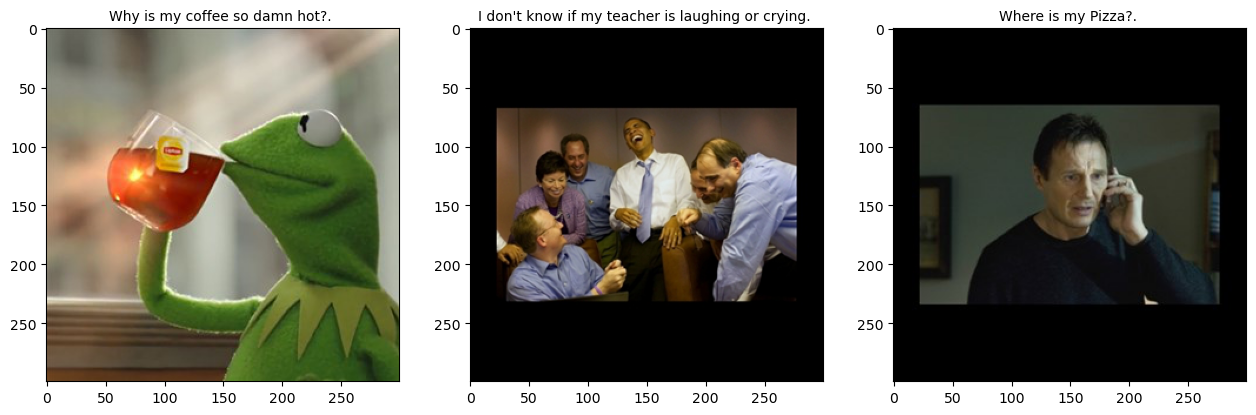

In [42]:
for i, img_path in enumerate(img_paths):
    image = Image.open(img_path)
    plt.subplot(1, len(img_paths), i+1)
    plt.imshow(image)
    plt.title(f"{user_prompts[i]}. ", loc='center', wrap=True)
plt.subplots_adjust(right=2)
plt.show()

## CLIP Training : Classification



In [36]:
os.path.abspath(img_paths[0])

'/home/s1hegde/teams/shaolin-monkeys/memes900k/images/kermit-the-frog-drinking-tea.jpg'

In [38]:
data.keys()

dict_keys(['label_uuid_dic', 'uuid_label_dic', 'uuid_caption_dic', 'uuid_image_path_dic'])

In [39]:
from transformers import CLIPTokenizer

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


Moving 0 files to the new cache system


0it [00:00, ?it/s]

In [40]:
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-base-patch32")

In [41]:
captions = data['uuid_caption_dic'][uuids[0]]
captions

[['this tea is actually hennessy', "but that's none of your business."],
 ['almost every place was looted except the library',
  "but that's none of my business"],
 ["if you didn't do shady stuff, people wouldn't snitch",
  "but that's none of my business"],
 ['facebook is a factory farm for human beings',
  'but spend time on it if you want'],
 ['oh tlc canceled honey boo boo?', "i didn't notice..."],
 ['when you have beer', 'and you put a tea bag in it so it looks like tea'],
 ["maybe don't do meth and throw rocks at cops",
  "but that's none of my business."],
 ['another celebrity dies of prescription drug overdose',
  "but that's none of my business"],
 ['yeah, i fuck pigs. so what?', "grover abused me back in the 70's"],
 ["here's to me for being a meme",
  "because of that i'm the only muppet anyone really knows anymore"],
 ['#healthy yet all your pics be #fastfood', "but that's none of my business"],
 ['mmmmm this is good', "you were expecting a meme? i don't care"],
 ['antifa',

In [42]:
string1 = ','.join(captions[0])
string1

"this tea is actually hennessy,but that's none of your business."

In [45]:
tokenizer.tokenize(string1)

['this</w>',
 'tea</w>',
 'is</w>',
 'actually</w>',
 'hennessy</w>',
 ',</w>',
 'but</w>',
 'that</w>',
 "'s</w>",
 'none</w>',
 'of</w>',
 'your</w>',
 'business</w>',
 '.</w>']

In [46]:
len(captions)

3000

In [24]:
from clip_training.dataloader import *

In [25]:
import torchvision
print(torchvision.__version__)

0.13.1+cu102


In [26]:
uuids = ['3916f238-fcf4-459a-b711-77bd948eb9e0',
 'd3da6277-c6dc-481c-a85e-1bf9943f058a',
 'ce6d3b49-8929-4bf3-85f0-c073dfe10a0a']

In [27]:
img.size

(300, 300)

In [28]:
transform = Transform(img.size, False, None)

In [29]:
dataset = ImageTextDataset(data, uuids, False, transform)

9000 9000


In [30]:
dataset[0]

TypeError: Input img should be Tensor Image

In [ ]:
from torchvision.datasets import 